# A/B Test for E-Commerce

In this project we conduct an A/B test for a fictional e-commerce website, **_Audacity_**. The objective is to analyse the results of an A/B test run by Audacity and recommend action on whether to implement their new webpage, continue using their old web-page or collect more experimental data.

## Data Overview

The dataset used in this project is provided by Udacity as part of their Data Analyst Nanodegree programme. 

* **`ab_data.csv`** -  Contains `user_id`, `timestamp`, `group` (control or treatment), `landing_page` (old_page or new_page) and whether each user `converted` or not.
* **`countries.csv`** - Contains `user_id` and `country` information

In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import os
import sys

%matplotlib inline

path = os.path.abspath(os.path.join('../features'))
if path not in sys.path:
    sys.path.append(path)

import visualise as vis

# Seed random to keep values common for each execution
np.random.seed(42)

In [27]:
df_ab = pd.read_csv('../data/ab_data.csv')
df_country = pd.read_csv('../data/countries.csv')

## Data Assessment

In [28]:
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [29]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


* No null values in any column
* Timestamp is object not datetime

In [30]:
df_ab.user_id.duplicated().sum(), df_ab.duplicated().sum()

(3894, 0)

* There are 3894 duplicate `user_id`'s who have visited more than once.
* None of the rows are duplicated

In [31]:
df_ab[df_ab.user_id.duplicated(keep=False)].sort_values(by='user_id').head(10)

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
11792,630137,2017-01-22 14:59:22.051308,control,new_page,0
207211,630320,2017-01-07 18:02:43.626318,control,old_page,0
255753,630320,2017-01-12 05:27:37.181803,treatment,old_page,0
96929,630471,2017-01-07 02:14:17.405726,control,new_page,0
110634,630471,2017-01-23 01:42:51.501851,control,old_page,0


In [32]:
print("Rows misaligned:", (((df_ab.group == "control")&(df_ab.landing_page != "old_page"))|\
        ((df_ab.group == "treatment")&(df_ab.landing_page != "new_page"))).sum())

Rows misaligned: 3893


* There are 3893 rows with mismatched `group` and `landing_page` variables where:
    * `control != old_page` OR `treatment != new_page`

In [33]:
df = df_ab[(((df_ab.group == "control")&(df_ab.landing_page == "old_page"))|\
        ((df_ab.group == "treatment")&(df_ab.landing_page == "new_page")))]

df[df.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


* There is only one duplicated `user_id` in the sample whcih does not have mismatched `group` and `landing_page`. * They were exposed to the new page twice and converted neither times.

In [34]:
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


* `df_country` contains the `user_id` and `country` information. 
* `user_id` is a primary key we can merge the dataframes on

In [35]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [36]:
df_ab.user_id.nunique(), df_country.user_id.nunique()

(290584, 290584)

* There number of unique `user_id`'s in each dataframe are equal.
* There are no duplicated `user_id`'s in `df_country`

### Assessment Summary
* No null values in any column
* Timestamp is object not datetime
* There are 3894 duplicate `user_id`'s who have visited more than once.
* None of the rows are duplicated
* There are 3893 rows with mismatched `group` and `landing_page` variables where:
    * `control != old_page` OR `treatment != new_page`
* There is only one duplicated `user_id` in the sample whcih does not have mismatched `group` and `landing_page`.
* There number of unique `user_id`'s in each dataframe are equal.
* There are no duplicated `user_id`'s in `df_country`
***
### Define Fixes
* Convert `timestamp` to datetime
* Drop rows with misaligned `group` and `landing_page` variables
* Drop one instance of the remaining duplicated `user_id` to ensure conversion rates apply to only unique users.
* Merge `country` from `df_country` into `df_ab`
***
### Code & Test

In [37]:
## Create copy of df_ab
df_clean = df_ab.copy()

In [38]:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [39]:
## Remove misalgined group and landing pages
df_clean = df_ab[(((df_ab.group == "control")&(df_ab.landing_page == "old_page"))|\
                ((df_ab.group == "treatment")&(df_ab.landing_page == "new_page")))]

assert all(df_clean[df_clean.group == "control"].landing_page == 'old_page')
assert all(df_clean[df_clean.group == "treatment"].landing_page == 'new_page')

In [40]:
## Drop duplicated user_id
df_clean = df_clean[~df_clean.user_id.duplicated()]

assert not all(df_clean.user_id.duplicated())

In [41]:
df_clean = df_clean.merge(df_country, on='user_id', how='left')
df_clean.to_csv('../data/ab_data_clean.csv', index=False)
df_clean.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


We have addressed all of the issues raised and are now ready to analyse the dataset.

## Analysis of A/B Test Results

The metric we'll use to assess the performance of each page is click through rate (CTR) which describes the proportion of uses who converted. Lets construct our null and alternative hypothesese:

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

Given the hypotheses, we will accept a type I error tolerance of: $$\alpha \leq 5\%$$
***
Lets separate out out treatment and control groups into two new dataframes and calculate the proportions of users converted.

In [17]:
# Construct df's for each group
df_new = df_clean[df_clean.landing_page=="new_page"]
df_old = df_clean[df_clean.landing_page=="old_page"]

In [18]:
print("p_total: ", df_clean.converted.mean())
print("p_new: ", df_new.converted.mean())
print("p_old: ", df_old.converted.mean())
print("p_new - p_old: ", df_new.converted.mean() - df_old.converted.mean())

p_total:  0.11959708724499628
p_new:  0.11880806551510564
p_old:  0.1203863045004612
p_new - p_old:  -0.0015782389853555567


This initial assessment suggests that the proportion of users who converted is marginally larger (0.16%) for those exposed to the old page than the new page and therefore we cannot reject the null. 

To give this assessment statistical significance lets create a sample distribution for the difference in conversion rates through bootstrapping.

In [19]:
start = datetime.now()
diffs=[]
for _ in range(10000):
    boot_new = np.random.choice(df_new.converted, df_new.shape[0], replace=True)
    boot_old = np.random.choice(df_old.converted, df_old.shape[0], replace=True)
    diffs.append(np.mean(boot_new)-np.mean(boot_old))
    
end = datetime.now()
runtime = end - start
print(runtime)

0:01:23.323290


/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


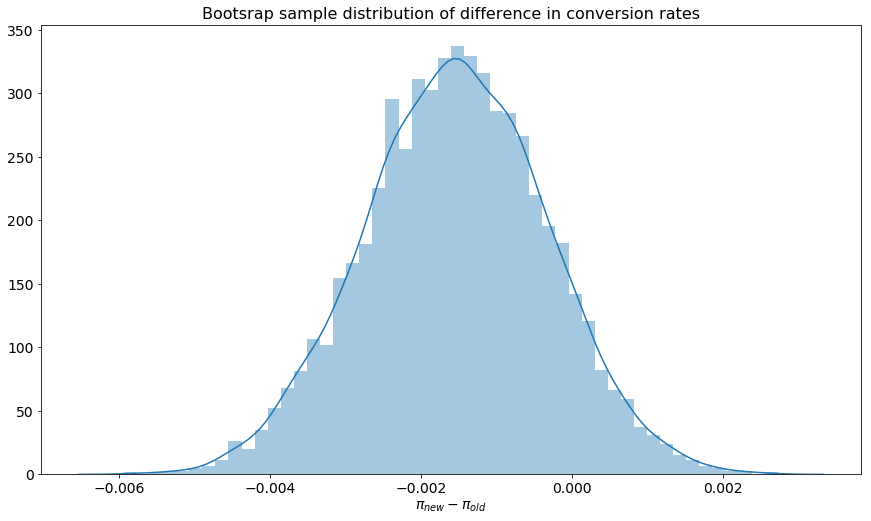

In [20]:
vis.createPlot()
sb.distplot(diffs);
plt.title("Bootsrap sample distribution of difference in conversion rates", fontsize=16);
plt.xlabel("$\pi_{new} - \pi_{old}$");

We can simulate the sampling distributions using an alternative method which avoids the use of a computationally expensive for loop by generating binomial distrubutions using the sample means as probability of conversion.

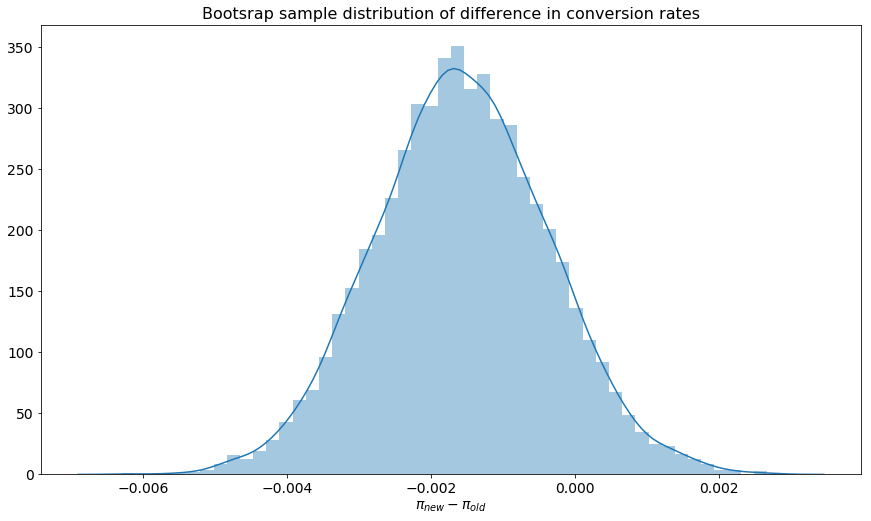

In [21]:
start = datetime.now()
p_new = np.random.binomial(df_new.shape[0], df_new.converted.mean(),10000)/df_new.shape[0]
p_old = np.random.binomial(df_old.shape[0], df_old.converted.mean(),10000)/df_old.shape[0]
p_diffs = p_new - p_old

end = datetime.now()

vis.createPlot()
sb.distplot(p_diffs);
plt.title("Bootsrap sample distribution of difference in conversion rates", fontsize=16);
plt.xlabel("$\pi_{new} - \pi_{old}$");

runtime2 = end - start

In [22]:
print("Loop runtime:", runtime)
print("Binomial runtime:", runtime2)
print("Delta:", runtime - runtime2)

Loop runtime: 0:01:23.323290
Binomial runtime: 0:00:00.003581
Delta: 0:01:23.319709


There is a huge difference in runtime speeds between the 2 methods used. The initial mehtod which made us of a for loop computes in 1 minute 20 seconds on my computer, whilst the method which uses a normalised binomial distribution computes in 3 millseconds.

We can use the standard deviation of sampling distribution `p_diffs` to generate a distribution from the null then caluclate the p-value.

std 0.0012072359677520355


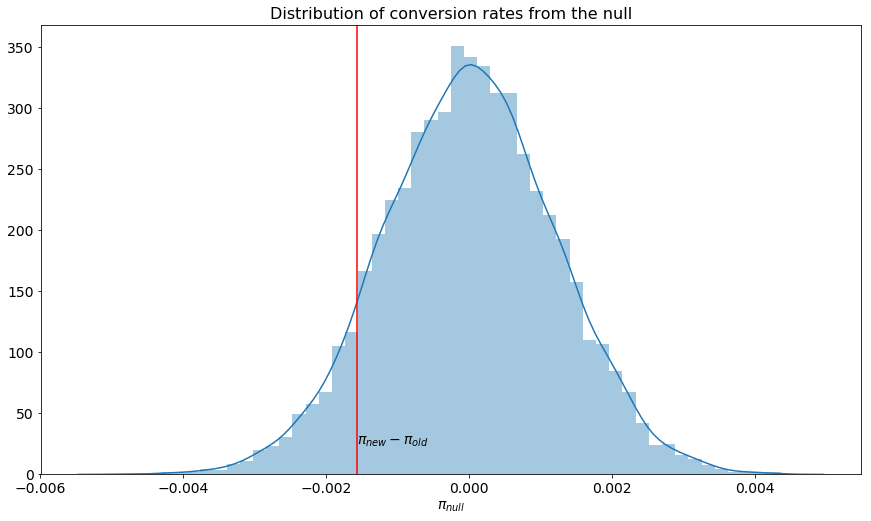

In [23]:
print("std", np.std(p_diffs))
nulls = np.random.normal(0, np.std(p_diffs), 10000)

vis.createPlot();
sb.distplot(nulls);
plt.title("Distribution of conversion rates from the null", fontsize=16);
plt.xlabel("$\pi_{null}$", fontsize=14);
plt.axvline(np.mean(p_diffs), color='r');
plt.text(np.mean(p_diffs), 25, "$\pi_{new} - \pi_{old}$", rotation=0, fontweight='bold', fontsize=14);

In [24]:
p_val = (nulls > np.mean(p_diffs)).mean()
print("p-value:", p_val)

p-value: 0.9099


## Conclusion
The p-value of 0.9099 tells us that the probability of observing our value for $\pi_{new}-\pi_{old}$ or one that favours the alternative more strongly is 91%, given that the null is true. Specifically: $$ P(\pi_{diff}\geq-0.15|H_0=True) = 0.91$$

Given a target tolerance for type I error rate of: $\alpha \leq 5\%$, we fail to reject the null hypothesis. Therefore, my recommendation is that the e-commerce site should **not** roll out their new web-page.
***
## Regression Analysis
Given that user conversion is binary, another method we can use to investigate the probability of conversion is logistic regression.